# `snow2`

The SNOW algorithm uses a standard marker-based watershed segementation function to identify pores. The key to the SNOW algorithm is in how the markers are identified. Finding peaks in the distance transform which truly correspond to pore centers requires several careful steps. Each of these steps can be done manually, but the ``snow2`` function was created to combine them all in a single function for ease of use. 

In addition to the original SNOW algorithm, ``snow2`` also incorporates a few new developements such as [multiphase extractions](https://doi.org/10.1016/j.compchemeng.2018.12.025) and [parallelized processing](https://doi.org/10.1016/j.advwatres.2020.103734).  The new ``snow2`` function also handles boundaries better, and returns a different set of geometrical properties.  For instance it no longer returns 'pore.diameter', which was an opinionated choice that was not appropriate for every case. Instead it returns several different diameters, like 'pore.equivalent_diameter' and 'pore.inscribed_diameter', and the user must decide which of these they wish to declare as the offical 'pore.diameter'. 

The ``snow2`` function has quite a few arguments, which will be explored and explained in this example.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openpnm as op
import scipy.ndimage as spim
from edt import edt

import porespy as ps

D:\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


No module named 'pyedt'


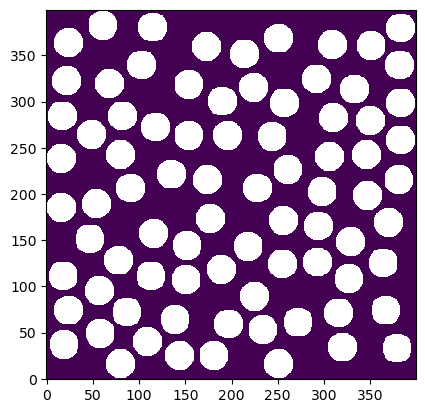

In [2]:
im = ~ps.generators.random_spheres([400, 400], r=15, clearance=5)
ps.imshow(im);

## `phases`

One of the main features of ``snow2`` is the ability to extract networks from multiple phases simultaneously, and have them be interconnected.  This is quite useful for modeling electrochemial devices for instance, since transport occurs in the solid and void phases simultaneously, and the processes are coupled. For a powerful example, see [Khan et al.](https://doi.org/10.1149/1945-7111/ac120c) where the transient discharage of a Li-ion battery was modelled using PNMs. Li-ion batteries contain 3 distinct phases: liquid electrolyte, solid active material, and carbonaceous binder.  

Note that ``snow2`` does not *need* to operate on mulitphase phases, only that it *can* if needed.  It accomplishes this flexibility by ignoring all 0's in the input images, and treating all voxels with values of 1, 2, 3, etc. as distinct phases. Therefore supplying an image of 0's and 1's will result in a standard single phase extraction, while supplying an image of 1's and 2's will create a dual phase network. 

A few additional notes:

- It should also be mentioned that the image can contain 0's as well as values (ie. 1, 2, 3), so can have multiple phases *and* have some regions ignored
- The voxels values do not have be integers or sequential.  Each unique numerical value in the image is treated as phase. 

Let's explore this:

In [3]:
im.min()

False

In [4]:
net1 = ps.networks.snow2(phases=im, boundary_width=0)
net2 = ps.networks.snow2(phases=im.astype(int) + 1, boundary_width=0)

The "object" returned by the ``snow2`` function is a dataclass-like object, meaning it has data attached to it as attributes.  These attributes are the segmented image called ``regions``, the OpenPNM compatible network called ``network``, and a copy of the input image called ``phases`` which will be padded to be the same size as ``regions`` *if* any boundaries were added. 

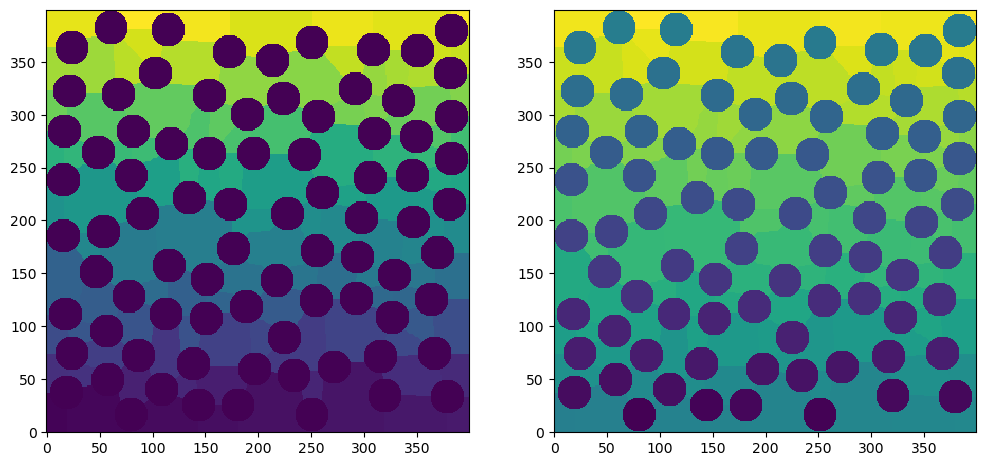

In [5]:
fig, ax = plt.subplots(1, 2, figsize=[12, 6])
ax[0].imshow(net1.regions, origin='lower', interpolation='none')
ax[1].imshow(net2.regions, origin='lower', interpolation='none');

On the left we can see that the spherical particles are all purple, which indicates 0, because they have not been labelled by the function.  On the right the particles each have a unique greyscale value because they have been labelled as distinct regions.  

The returned objects (`net1` and `net2`) also contain the pore networks, in OpenPNM format. We can overlay these networks with the above images.  Let's start with the single phase network:

In [6]:
pn1 = op.io.network_from_porespy(net1.network)

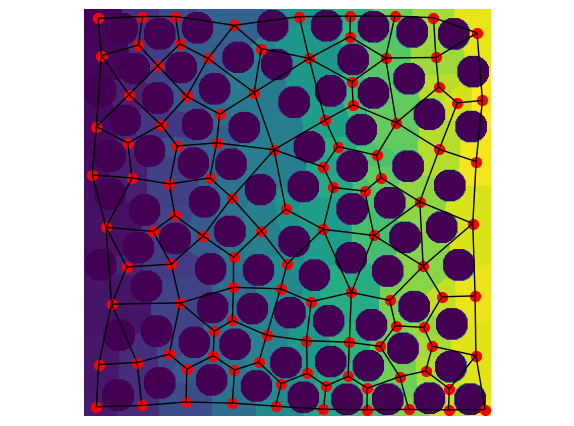

In [7]:
ax = op.visualization.plot_connections(pn1, c='k')
ax = op.visualization.plot_coordinates(pn1, markersize=50, ax=ax)
fig, ax = plt.gcf(), plt.gca()
ax.imshow(net1.regions.T)
ax.axis(False);

The image needed to be rotated so that the x and y directions lined up with the OpenPNM network.  The agreement between the image and network is pretty good.  Clearly the the red pore centers lie within each labelled regions and the black throat connections follow the topology quite well.  

Now let's do the same for the multiphase network:

In [8]:
pn2 = op.io.network_from_porespy(net2.network)

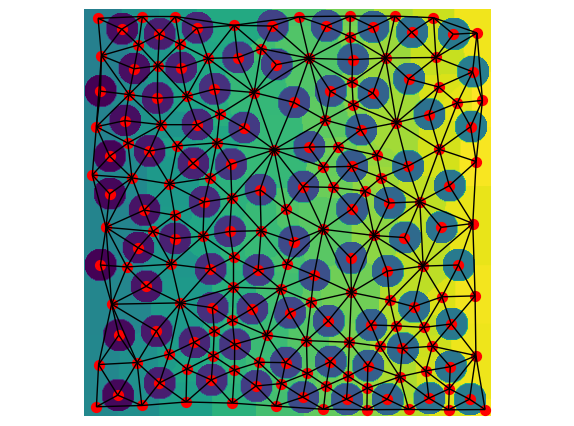

In [9]:
ax = op.visualization.plot_connections(pn2, c='k')
ax = op.visualization.plot_coordinates(pn2, markersize=50, ax=ax)
fig, ax = plt.gcf(), plt.gca()
ax.imshow(net2.regions.T)
ax.axis(False);

The above shows the additional network comprised of the solids (although they don't actually connect in this 2D example) as well as the void-solid connections.  We can improve this plot by coloring the different types of pores and throats differently.  If we print ``pn2`` we can see that ``snow2`` has created some labels for us, by assuming phase names of "phase1" and "phase2". 

In [10]:
print(pn2)

throat.conns
[[  0  82]
 [  0  83]
 [  0  90]
 ...
 [183 187]
 [184 188]
 [186 188]]
<class 'numpy.ndarray'>
int32
pore.coords
[[ 16.          80.           0.        ]
 [ 16.         251.           0.        ]
 [ 25.         144.           0.        ]
 [ 25.         181.           0.        ]
 [ 33.         379.           0.        ]
 [ 34.         320.           0.        ]
 [ 37.          19.           0.        ]
 [ 40.         109.           0.        ]
 [ 49.          58.           0.        ]
 [ 53.         234.           0.        ]
 [ 59.         197.           0.        ]
 [ 61.         272.           0.        ]
 [ 64.         139.           0.        ]
 [ 71.         316.           0.        ]
 [ 72.          87.           0.        ]
 [ 74.          24.           0.        ]
 [ 74.         367.           0.        ]
 [ 89.         225.           0.        ]
 [ 95.          57.           0.        ]
 [107.         151.           0.        ]
 [108.         327.           0. 

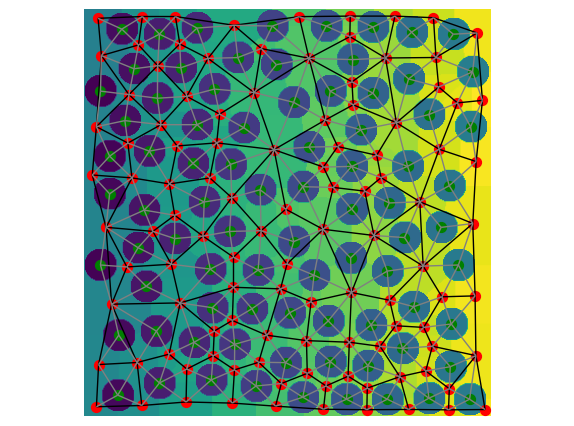

In [11]:
ax = op.visualization.plot_connections(pn2, throats=pn2['throat.phase2_phase2'], c='k')
ax = op.visualization.plot_connections(pn2, throats=pn2['throat.phase2_phase1'], c='grey', ax=ax)
ax = op.visualization.plot_coordinates(pn2, pores=pn2['pore.phase2'], c='r', markersize=50, ax=ax)
ax = op.visualization.plot_coordinates(pn2, pores=pn2['pore.phase1'], c='g', markersize=50, ax=ax)
fig, ax = plt.gcf(), plt.gca()
ax.imshow(net2.regions.T)
ax.axis(False);

Now can see the particles are indicated by a green marker, the void pores by a red marker, the solid-void interconnections are in grey, and the void-void throats are black.  

## `phase_alias`

In the previous section the default phase names created by `snow2` were the uncreative "phase1" and "phase2". The `snow2` function allows for these to be given more desriptive names.  This is done by supplying a dictionary with the voxels value as the key and the desired phase name as the value.  

In [12]:
net3 = ps.networks.snow2(phases=im.astype(int) + 1, phase_alias={1: 'solid', 2: 'void'}, boundary_width=0)

In [13]:
pn3 = op.io.network_from_porespy(net3.network)
print(pn3)

throat.conns
[[  0  82]
 [  0  83]
 [  0  90]
 ...
 [183 187]
 [184 188]
 [186 188]]
<class 'numpy.ndarray'>
int32
pore.coords
[[ 16.          80.           0.        ]
 [ 16.         251.           0.        ]
 [ 25.         144.           0.        ]
 [ 25.         181.           0.        ]
 [ 33.         379.           0.        ]
 [ 34.         320.           0.        ]
 [ 37.          19.           0.        ]
 [ 40.         109.           0.        ]
 [ 49.          58.           0.        ]
 [ 53.         234.           0.        ]
 [ 59.         197.           0.        ]
 [ 61.         272.           0.        ]
 [ 64.         139.           0.        ]
 [ 71.         316.           0.        ]
 [ 72.          87.           0.        ]
 [ 74.          24.           0.        ]
 [ 74.         367.           0.        ]
 [ 89.         225.           0.        ]
 [ 95.          57.           0.        ]
 [107.         151.           0.        ]
 [108.         327.           0. 

Now we can see that the phases are named using our preferred nomenclature of "solid" and "void".  This is helpful if you have several phases like "electrolyte", "binder", "particles" for instance.

## `boundary_width`

Adding pores (or more generally nodes) on the boundaries of images is helpful when conducting transport simulations. Without boundary pores then boundary condtions must be applied to internal pores which are (a) hard to identify clearly and (b) make it impossible to know the exact length of the domain. 

> Note that boundary nodes are not physical and thus their sizes are ficticious.  This can cause problems when computing the transport conductance for these nodes, so care must be taken.

The `boundary_width` argument was designed to work analogously to the ``numpy.pad`` function.  You can specify different paddings along each axis and also along each face.  For instance, here are some options (for a 2D image):

- ``[0, 3]``: 3 voxels only applied to the y-axis.
- ``[0, [0, 3]]``: 3 voxels only applied to the end of y-axis.
- ``[0, [3, 0]]``: 3 voxels only applied to the beginning of y-axis.

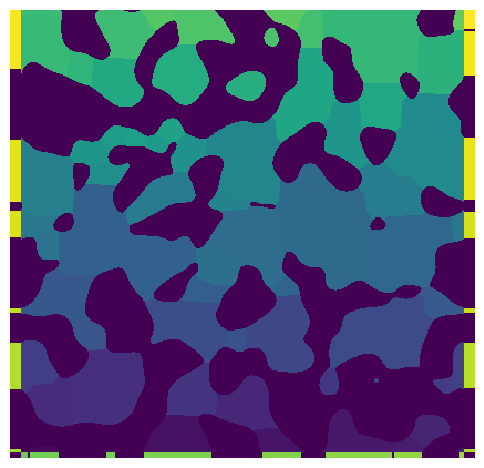

In [14]:
im = ps.generators.blobs([400, 400], porosity=0.6)
a = ps.networks.snow2(im, boundary_width=[[5, 0], 10])
fig, ax = plt.subplots(figsize=[6, 6])
ax.imshow(a.regions, origin='lower', interpolation='none')
ax.axis(False);

A few things to note:
- The image contains regions on the left, right and bottom faces, which are added by padding the image *after* the segmentation was applied, then incrementing labels the padded regions so their labels are greater than any inside the original image.
- These new regions are then treated like a normal region when the network topology and geometry is extracted.
- The width of each boundary region is nearly the same as the corresponding internal regions, but they are only a few voxels thick (in this case because we specified 5 or 10). This means that the value of 'pore.inscribed' sphere for this regions will almost all be 5 or 10 voxels. 
- The solid touching the boundaries creates gaps in the boundary regions.
- Two boundary regions neighboring each other are separated by 2 voxels.  This prevents them from being considered as connected during the topology extraction stage.
- The top and bottom of the image do not have any boundaries because we set the widths to 0 on this axis. 


It is instructive to visualize the network over the image to see how the boundary pores work:

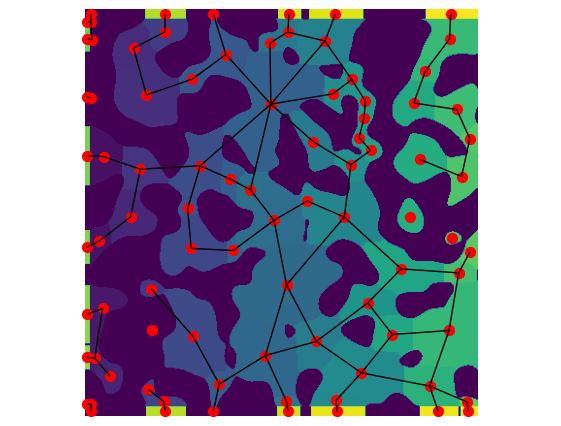

In [15]:
pn = op.io.network_from_porespy(a.network)
ax = op.visualization.plot_connections(pn, c='k')
ax = op.visualization.plot_coordinates(pn, markersize=50, ax=ax)
fig, ax = plt.gcf(), plt.gca()
ax.imshow(a.regions.T)
ax.axis(False);

## `accuracy`

This argument can either take the value of `'high'` or `'standard'`, with standard being the default.  It is not recommended to use `'high'` since this uses some rather slow functions to measure the surface areas and perimeters.  The increase in accuracy is basically futile since (a) the image has already been reduced to a coarse voxelization and (b) the pore network abstraction discards information about the actual microstructure in exchange for speed, so spending ages on the extraction step would undermine this purpose. 

## `voxel_size`

This is the voxel size of the image, as in the length of one side of a voxel.  Typical microtomography images are in the range of 1-5 um per voxel.  NanoCT can be as low as 16 nm per voxel.  FIB-SEM might be 4 nm per voxel.  Note that all properties returned from the ``snow2`` function, like 'pore.volume' will be in the same units are this value. It is *strongly* recommended to use SI, which is assumed in OpenPNM for most of the fluid property calculations. 

## `sigma` and `r_max`

These values are passed on to the `gaussian_blur` and `find_peaks` functions. 

The `gaussian_blur` is applied to the distance transfrom, which as discussed in the [original snow paper](https://doi.org/10.1103/PhysRevE.96.023307) is a very effective way to reduce the number of incorrect peaks that are found in the subsequent steps.  A value of `sigma=0.4` is the default.

The `find_peaks` function applies a maximum filter to the distance transform, which replaces each voxel with the maximum it finds with the specified neighborhood.  It then looks for voxels that are the same between the filtered image and the original distance transform.  Only voxels that are local maximas will be the same between the images.  

The following code block illustrates the impact of applying the `gaussian_blur` filter on finding peaks. 

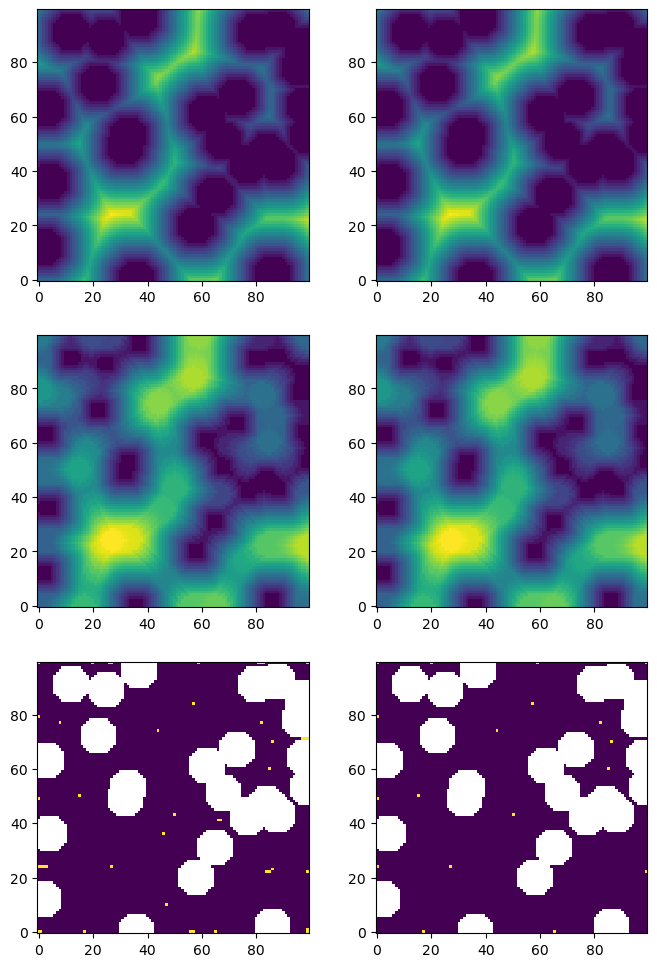

In [16]:
np.random.seed(13)
im = ps.generators.overlapping_spheres([100, 100], r=7, porosity=0.7)
dt = edt(im)
mx1 = spim.maximum_filter(dt, footprint=ps.tools.ps_disk(r=4, smooth=False))
pk1 = dt == mx1
dt_blur = spim.gaussian_filter(dt, sigma=0.4)
mx2 = spim.maximum_filter(dt_blur, footprint=ps.tools.ps_disk(r=4, smooth=False))
pk2 = dt_blur == mx2
fig, ax = plt.subplots(3, 2, figsize=[8, 12])
ax[0][0].imshow(dt, origin='lower', interpolation='none')
ax[1][0].imshow(mx1, origin='lower', interpolation='none')
ax[2][0].imshow(pk1/im, origin='lower', interpolation='none')
ax[0][1].imshow(dt_blur, origin='lower', interpolation='none')
ax[1][1].imshow(mx2, origin='lower', interpolation='none')
ax[2][1].imshow(pk2/im, origin='lower', interpolation='none');

## `peaks`

Because finding correct peaks is such an important part marker-based watershed segmentationa, and therefore of ``snow2``, it is possible to supply custom peaks found using any desired process. Obviously, if this is provided then `sigma` and `r_max` are ignored.

Let's use the two sets of peaks found above:

In [17]:
net1 = ps.networks.snow2(phases=im, boundary_width=0, peaks=pk1)
net2 = ps.networks.snow2(phases=im, boundary_width=0, peaks=pk2)

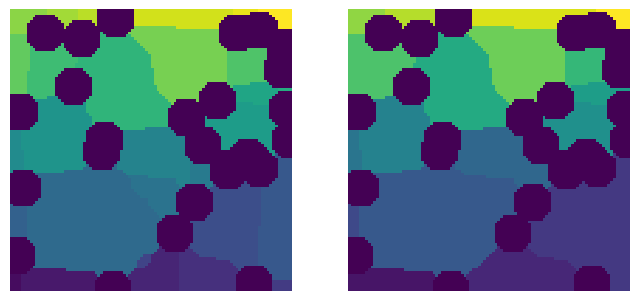

In [18]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
ax[0].imshow(net1.regions, origin='lower', interpolation='none')
ax[1].imshow(net2.regions, origin='lower', interpolation='none')
ax[0].axis(False)
ax[1].axis(False);

Clearly the image on the left is 'over segmented' while the image on the right seems to have identified the pores nearly perfectly, even without subsequent processing of the peaks that normally occur in ``snow2`` like ``trim_saddle_points`` and ``trim_nearby_peaks``.

## `parallelization`

The watershed function was identified as the bottleneck of the entire process, especially as images grew in size. Parallelization of the watershed function had not be throughly investigated in the literature, so [Khan et al](https://doi.org/10.1016/j.advwatres.2020.103734) developed a basic protocol for dividing the image into chunks and processing each in parallel. The main challenge with this approach was ensuring sufficient overlap was allowed to prevent any artifacts, while not being overly conservative since large overlaps undermine the speedup obtained by parallelization. The parallelization if accomplished by [dask](https://www.dask.org/) which makes it trivial to dispatch duplicate jobs to different cores. 

The ``snow2`` function can optionally parallelize the watershed step. It calls `porespy.filters.snow_partitioning_parallel` behind the scenes, but this function requires several arguments.  Instead of complicating the ``snow2`` function signature, we instead chose to accept a `dict` of arguments and values which are then passed on.  These are:

- `divs`: The number of chunks to divide the image into.  A value of 2 means the image is divided in hald along each axis, for a total of 8 chunks in a 3D image.  It's possible to specify a different number of divisions in each direction, like `divs=[2, 2, 1]`.  This could be useful if the image to be processed is very narrow in one direction, such as a piece of fibrous electrode.  

- `overlap`: This controls the amount of overlap between each chunk in voxels. Specifying `None` (the default) means that the algorithm finds the overlap automatically. Khan el al found that using the maximum of the distance tranform was suitable. 

- `cores`: This controls the number of cores to use when processing the chunks. If not provided then all cores will be used. This may be problematic on computers without a large amount of RAM since each process will consume some RAM.  In these cases in may be beneficial to set cores to a small number and simply wait longer for the result.

If ``parallel_kw=None`` then no parallelization is applied, while if ``parallel_kw={}`` then the default arguments of the ``snow_partitioning_parallel`` function are used.  

In the following code block, the parallelization option is demonstrated with an `overlap` that is too small, resulting in a noticable artifacts in the center sectionof the watershed segmentation, where the divsions were located. For comparison, the same image is processed with the default overlap.

In [19]:
np.random.seed(0)
im = ps.generators.overlapping_spheres([400, 400], r=20, porosity=0.8)
parallel_kw = {'cores': 1, 'divs': [2, 2], 'overlap': 1}
net1 = ps.networks.snow2(phases=im, parallel_kw=parallel_kw)
parallel_kw = {'cores': 1, 'divs': [2, 2], 'overlap': None}
net2 = ps.networks.snow2(phases=im, parallel_kw=parallel_kw)

[10:50:17] WARNING  Disabling paralelization as overlap exceeds than chunk size.                      _snow2.py:222

           WARNING  Disabling paralelization as overlap exceeds than chunk size.                      _snow2.py:222

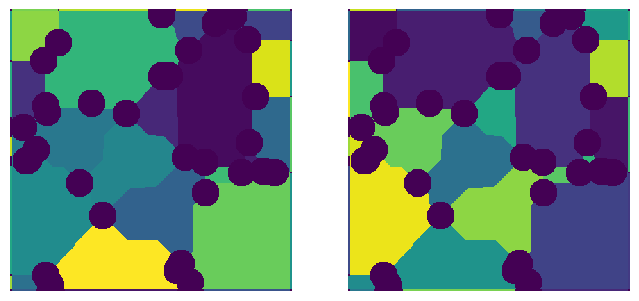

In [20]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
temp = ps.tools.randomize_colors(net1.regions)
ax[0].imshow(temp, origin='lower', interpolation='none')
ax[0].axis(False)
temp = ps.tools.randomize_colors(net2.regions)
ax[1].imshow(temp, origin='lower', interpolation='none')
ax[1].axis(False);